In [33]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

random_state = 42   

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from utils.data_visualizator import plot_confusion_matrixes, plot_confusion_matrix

from utils import DataAggregator
import pandas as pd

from tqdm import tqdm

from xgboost import XGBClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classifiers
Next up, we want to use classifying algorithms to predict the outcome of future matches. To do so, we will use the preprocess_data function described in the previous section. This data contains form data for each team, that hopefully will provide predictive power for the classifiers. We will also make use of multiple classifiers, using grid search to find the best from each of the classifiers.

In [34]:
data_aggregator = DataAggregator()
df = data_aggregator.preprocess_data(data_aggregator.get_data(["E0"]), 
                                     date_column="Date",
                                     home_team_column="HomeTeam",
                                     away_team_column="AwayTeam",
                                     result_column="FTR",
                                     form_window=10)

In [35]:
df.head()

,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,Year,Month,Day,DayOfWeek,HomeTeamPPG,AwayTeamPPG,HomeTeamWinForm,AwayTeamWinForm,HomeTeamGoalForm,AwayTeamGoalForm,HomeTeamGoalAgainstForm,AwayTeamGoalAgainstForm
0,2002-08-17,3,36,0,1.727,3.25,4.333,2002,8,17,5,1.527222,0.731651,0.112222,0.430525,1.347879,0.887406,1.146061,1.752877
1,2002-08-17,34,26,0,2.250,3.25,2.750,2002,8,17,5,1.377308,0.820423,0.011608,0.359539,1.380350,0.849424,1.302308,1.493854
2,2002-08-17,25,40,1,1.200,5.00,12.000,2002,8,17,5,2.249272,0.804219,0.558561,0.362332,2.043601,0.867971,0.810680,1.645109
3,2002-08-17,11,12,-1,2.800,3.25,2.200,2002,8,17,5,1.467059,1.785437,0.060535,-0.258561,1.351872,1.607855,1.354011,1.055958
4,2002-08-17,16,5,1,1.727,3.25,4.333,2002,8,17,5,1.489933,0.956667,0.060769,0.288788,1.384808,1.003131,1.319341,1.673333


## Define and format train and test data
We also have to map the values of the labels into values starting from 0 to fit with some of the classifiers to be used.

In [36]:
target = "FTR"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train_df = df_train.drop(columns=[target, "Date"])
y_train = df_train[target].map({1: 2, 0: 1, -1: 0})
X_test_df = df_test.drop(columns=[target, "Date"])
y_test = df_test[target].map({1: 2, 0: 1, -1: 0})

We also scale the feature data, in order to fit the classifiers as best as possible.

In [37]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

## Defining the classifiers

In [38]:
model_lbls = [
    'dt' # decision tree
    ,'nb' # gaussian naive bayes
    ,'lp'   # linear perceptron
    ,'svc'  # support vector 
    ,'knn'  # k nearest neighbours
    ,'adb'  # adaboost
    ,'rf'   # random forest
    ,'xgb'  # xgboost
]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state), 
           'param': [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],                     
             },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state, algorithm="SAMME"),
           'param': [{'n_estimators':[*range(10,101,10)]
                     ,'learning_rate':[x / 100.0 for x in range(25, 251, 25)]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,30)]
                     ,'n_estimators':[*range(10,151,10)]}]
          },
    'xgb': {'name': 'XGBoost            ',
           'estimator': XGBClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,151,10)]
                     ,'learning_rate':[x / 100.0 for x in range(25, 251, 25)]}]
          }
}

## Performing a grid search

In [39]:
best_classifiers = {}
best_scores = {}

for model_lbl in tqdm(model_lbls):
    model = models[model_lbl]
    name = model['name'].strip()
    estimator = model['estimator']
    param_grid = model['param']
    
    grid_search = GridSearchCV(estimator=estimator, 
                               param_grid=param_grid, 
                               scoring='accuracy', 
                               cv=5, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    
    best_classifiers[model_lbl] = best_model
    best_scores[model_lbl] = {
        'Best Params': best_params,
        'CV Accuracy': best_score,
        'Test Accuracy': test_score
    }


 75%|███████▌  | 6/8 [14:59<05:06, 153.18s/it]/Users/andreasmarken/Desktop/Unibo/AI in Industry/project/venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
100%|██████████| 8/8 [21:47<00:00, 163.44s/it]


## Calculate and visualize the different performance metrics

In [40]:
result = {}

confusion_matrixes = {}

for model_lbl in model_lbls:
    model = best_classifiers[model_lbl]
    
    y_pred = model.predict(X_test)

    full_df = pd.concat([X_test_df.reset_index(drop=True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns=["Prediction"]).reset_index(drop=True)], axis=1)

    accuracy, won = data_aggregator.calculate_accuracy(full_df, "FTR", "Prediction")

    data_aggregator.save_metrics(f"{model_lbl}-classifier", accuracy, won)

    result[model_lbl] = [accuracy, won]

    confusion_matrixes[model_lbl] = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

In [41]:
pd.DataFrame(result, index=["Accuracy", "Won"])

,dt,nb,lp,svc,knn,adb,rf,xgb
Accuracy,0.560526,0.531579,0.394737,0.573684,0.534211,0.581579,0.573684,0.592105
Won,7592.200000,6933.100000,1213.100000,7688.000000,6985.200000,7729.500000,7654.700000,7830.800000


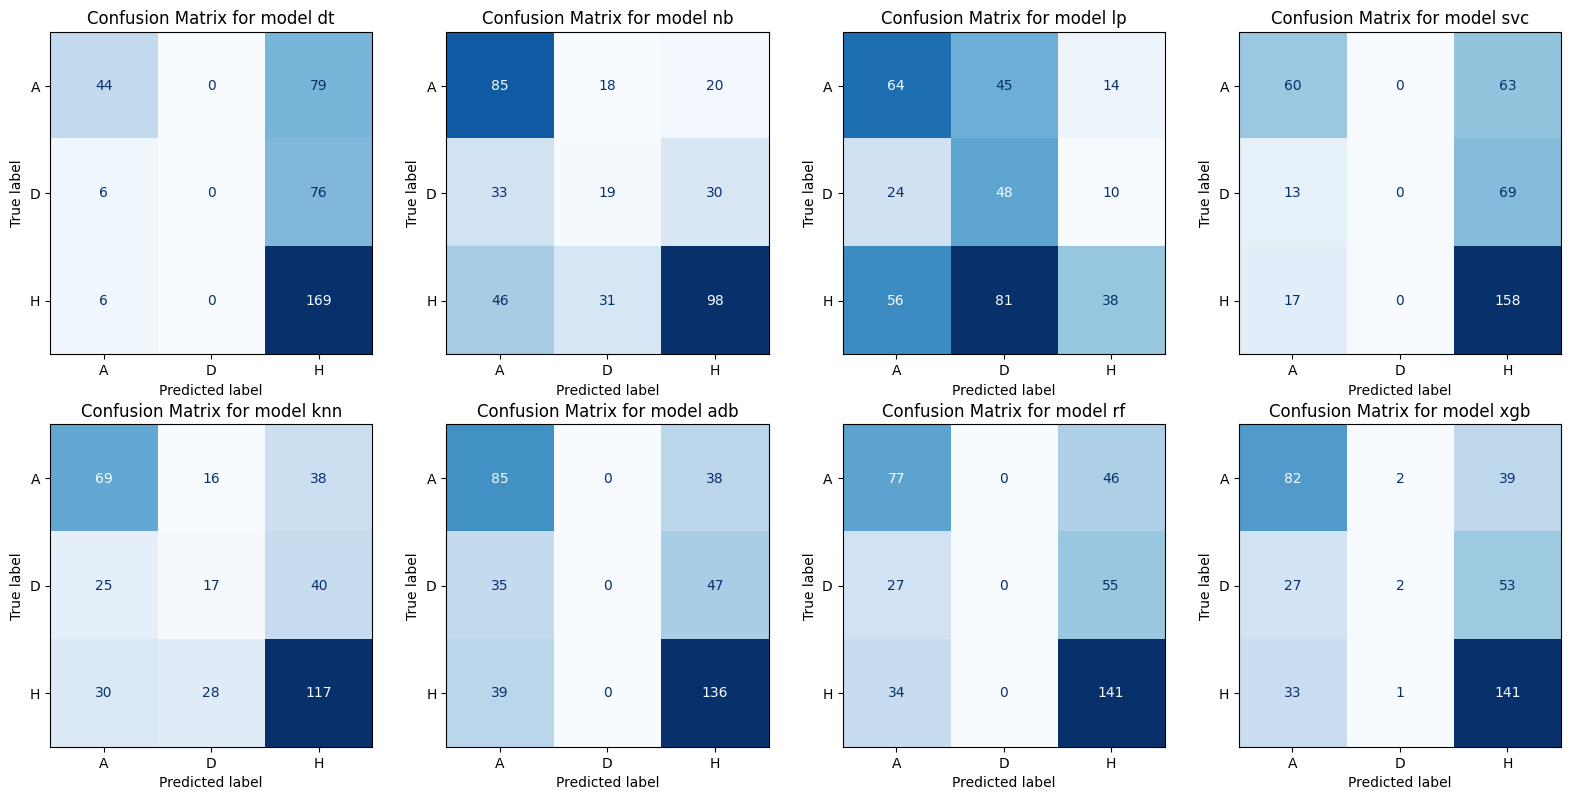

In [42]:
plot_confusion_matrixes(confusion_matrixes, classes=["A", "D", "H"])

As we can see from above, the models really struggles when predicting draws. The accuracy on home- and away wins, however, is somewhat okay. The model tends to be overly confident that a game is ending in a home win, suggesting that it has picked up on some of the bias from the dataset.

## Filtering out draws

Well, as we have just seen, predicting the draws can be a really challening task. Lets have a look at what happens if we filter out those draws from the dataset.

In [52]:
df = df[df["FTR"] != 0]

df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train_df = df_train.drop(columns=[target, "Date"])
y_train = df_train[target].map({1: 1, -1: 0})
X_test_df = df_test.drop(columns=[target, "Date"])
y_test = df_test[target].map({1: 1, -1: 0})

In [54]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

Instead of performing the full grid search again, we can see that the XGBoost classifier performed the best earlier. Lets use that to predict these new matches.

In [55]:
model = XGBClassifier(random_state=random_state, **best_scores['xgb']["Best Params"]).fit(X_train, y_train)

In [56]:
y_pred = model.predict(X_test)

full_df = pd.concat([X_test_df.reset_index(drop=True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns=["Prediction"]).reset_index(drop=True)], axis=1)

accuracy, won = data_aggregator.calculate_accuracy(full_df, "FTR", "Prediction")

In [57]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(full_df):.0f} out of {len(full_df)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 73.83%
The accuracy of the model is 220 out of 298 games.

With this model, the expected return on value would be 8509.70€


In [63]:
print("Classification report")
print(classification_report(y_test, y_pred))

Classification report
              precision    recall  f1-score   support

           0       0.70      0.63      0.67       123
           1       0.76      0.81      0.78       175

    accuracy                           0.74       298
   macro avg       0.73      0.72      0.73       298
weighted avg       0.74      0.74      0.74       298



First of all, we see that the accuracy is a lot higher. The accuracy of the model increases from $59.2$% to $73.8$% Furtermore, the recall and f1-score for home win is actually pretty good, suggesting that the model is able to capture some features that can acurrately predict home wins. Lets also have a look at the confusion matrix to see how it predicted the different labels.

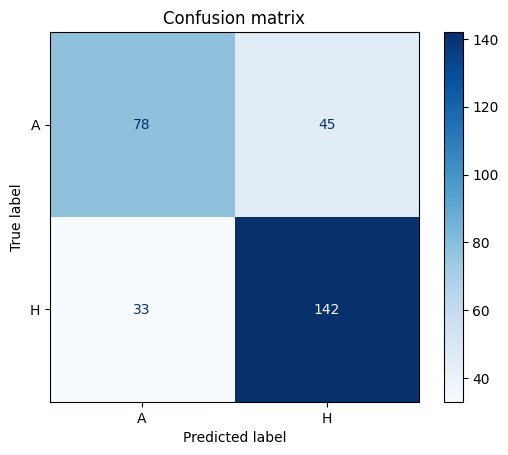

In [60]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=["A", "H"])

The first thing to notice is the strong diagonal from top left to bottom right, indicating that the model is able to accurately caputure these true positives.

In [61]:
data_aggregator.save_metrics("xgb-classifier (no draws)", accuracy, won)